# Experiments expanding on Ito et al. (2017)


In [1]:
import sys
sys.path.append('../utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm

## Import custom modules
# Primary module with most model functions
import model
# Module for FC regression
import multregressionconnectivity as mreg

## Experiment 1: GLM recovery of simulated task activity using information flow


### Create network

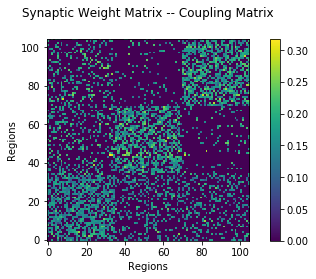

In [2]:
#### Set up subject network matrix ####
# Parameters for subject's networks
ncommunities = 3
innetwork_dsity = .60
outnetwork_dsity = .08
hubnetwork_dsity = .25

nodespercommunity = 35
totalnodes = nodespercommunity*ncommunities

# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=False)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)

### Simulate resting state activity using information flow model

Apply information flow model to the connectivity matrix and calculate each nodes' activity for each time point

**Note that this is still in synaptic space (i.e. not convolved)**

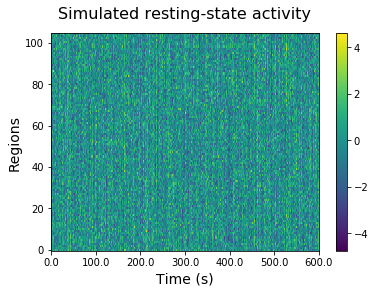

In [3]:
## Set up simulation parameters
Tmaxrest = 60000
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0
TRLength = 100

restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise = 1)

plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmaxrest+1,10000),np.arange(0,Tmaxrest+1,10000)/100)
plt.colorbar()

### Convolve resting state activity

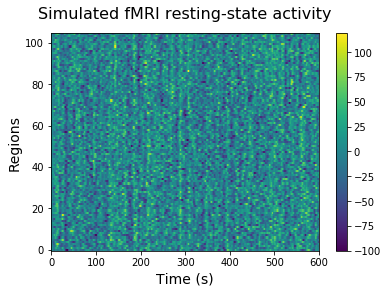

In [4]:
restfmri = model.convolveTimeseries(restdata,
                                    samplingrate=dt,
                                    TRLength=TRLength)
plt.figure()
plt.imshow(restfmri, aspect='auto',origin='lower')
plt.title('Simulated fMRI resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Recover connectivity matrix from resting state activity

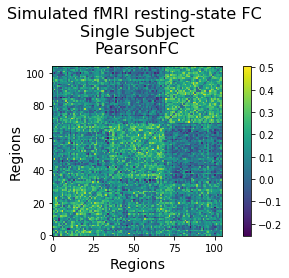

In [5]:
fcmat = np.corrcoef(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat,0)

plt.figure()
plt.imshow(fcmat, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC \nSingle Subject\nPearsonFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

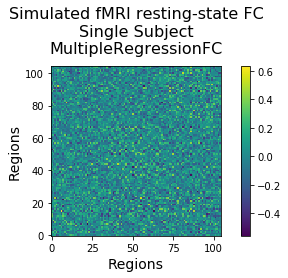

In [6]:
fcmat_mreg = mreg.multregressionconnectivity(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat_mreg,0)

plt.figure()
plt.imshow(fcmat_mreg, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC\nSingle Subject\nMultipleRegressionFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

### Simulate task activity using resting state

- Decide on the stimulus on/off for the I matrix
- How do you decide the task's spatial specificity, i.e. which network and nodes within a network it affects primarily? 
    - In the simulations the approach is: For topdown tasks only the hub network is simulated. E.g. for task 1 the first quarter of nodes are stimulated, for task 2 the next quarter etc. 
    - For topdown and bottom up (where a bug was fixed) it is a bit more complicated. E.g. for task 5 the first quarter of the hub network and the nodes of network 1 (first local network) that connect to the hub network (network 0) are stimulated
- Use model.networkmodel with G weights matrix and I task matrix

**For this example starting with a single top down task**

In [8]:
Ci = np.repeat(np.arange(ncommunities),nodespercommunity) # Construct a community affiliation vector
hub_ind = np.where(Ci==0)[0] # Identify the regions associated with the hub network (hub network is by default the 0th network)

# Set number of time points for each task
Tmax = 10000

T = np.arange(0,Tmax,dt)

taskdata = {}
stimtimes = {}
    
# Construct timing array for convolution -- this timing is irrespective of the task being performed
# Tasks are only determined by which nodes are stimulated
tasktiming = np.zeros((1,len(T)))
for t in range(len(T)):
    if t%2000>500 and t%2000<1000:
        tasktiming[0,t] = 1.0

topdown_only = range(1,5)
task = 1

taskcount = task-np.min(topdown_only)
stimsize = np.floor(nodespercommunity/4.0)
stim_nodes = np.arange((taskcount)*stimsize,(taskcount)*stimsize+stimsize,dtype=int)
stimtimes[task] = np.zeros((totalnodes,len(T)))

for t in range(len(T)):
    if tasktiming[0,t] == 1:
        # Task stimulation every 10 seconds for 4 seconds, excluding the first 10 seconds
        stimtimes[task][stim_nodes,t] = .5
        
taskdata[task] = model.networkModel(G,Tmax=Tmax,dt=dt,g=g,s=s,tau=tau,
                                          I=stimtimes[task], noise=1)

Block design task looks like:

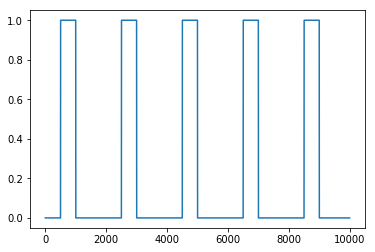

In [35]:
plt.plot(T, tasktiming[0])

Activated nodes in the hub network *only* (making it a top-down task) are:

In [30]:
stim_nodes

array([0, 1, 2, 3, 4, 5, 6, 7])

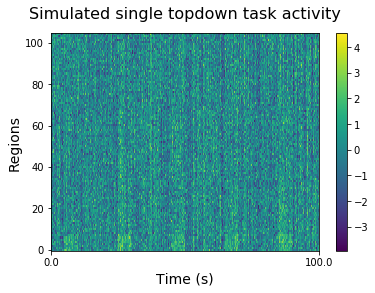

In [11]:
plt.figure()
plt.imshow(taskdata[1], aspect='auto',origin='lower')
plt.title('Simulated single topdown task activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmax+1,10000),np.arange(0,Tmax+1,10000)/100)
plt.colorbar()

### Convolve task activity 


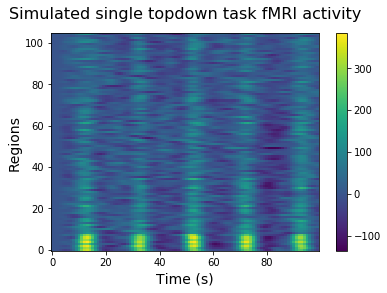

In [15]:
samplingrate=1.0
# Convolve simulated task data into fMRI signal
task_bold = model.convolveTimeseries(taskdata[task],
                               samplingrate=samplingrate, 
                               TRLength=TRLength)
plt.figure()
plt.imshow(task_bold, aspect='auto',origin='lower')
plt.title('Simulated single topdown task fMRI activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

### Run GLM on convolved task activity

How similar/different are the regions that the GLM recovers as 'significant' to ground truth?


In [22]:
n_skip_BOLD = int(TRLength)
# Temporally downsample task timing to seconds (before convolving)
timingconv = tasktiming[:,::n_skip_BOLD]
timingconv.shape = (timingconv.shape[1],)
hrfsample_rate=1.0 # HRF is sampled at seconds
hrfsample_times = np.arange(0, 30, hrfsample_rate, dtype=float)
hrf_at_simsample = model.hrf(hrfsample_times)
hrfconvtime = np.convolve(timingconv, hrf_at_simsample)
n_to_remove = len(hrf_at_simsample) - 1
convolved = hrfconvtime[:-n_to_remove]
# Output
timing_convolved_downsampled = convolved

In [24]:
task_betas_postfmri, task_resids_postfmri = model.runTaskGLM(task_bold, timing_convolved_downsampled)

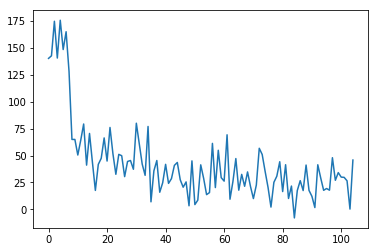

In [28]:
plt.plot(task_betas_postfmri)

## Experiment 2: How to subtract rest activity from task activity

Analogy: If i want to predict how my opinion changes at t+1 as a function of both my and the groups activity; the best predictor for it would likely be my opinion at t.

Known/measured: resting state BOLD; task BOLD; task timings/convolved predicted task BOLD  
Unknown/to be estimated: weights of G matrix?
